In [1]:
import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
from shapely import wkt

In [2]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata('data.sfgov.org', None)

# Get all results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get('5cei-gny5', limit=50000)

columns_to_remove = [
    ':@computed_region_6qbp_sg9q', ':@computed_region_qgnn_b9vv', ':@computed_region_26cr_cadq',
    ':@computed_region_ajp5_b2md', ':@computed_region_fyvs_ahh9', ':@computed_region_p5aj_wyqh',
    ':@computed_region_rxqg_mtj9', ':@computed_region_yftq_j783', ':@computed_region_bh8s_q3mv',
    ':@computed_region_6pnf_4xz7', ':@computed_region_jwn9_ihcz', ':@computed_region_pigm_ib2e',
    ':@computed_region_9jxd_iqea', ':@computed_region_6ezc_tdp2', ':@computed_region_h4ep_8xdi'
]

# Convert to pandas DataFrame
ev_df = pd.DataFrame.from_records(results).drop(columns=columns_to_remove)

# Convert file_date to datetime
ev_df['file_date'] = pd.to_datetime(ev_df['file_date'])

ev_df['eviction_type'] = ev_df.iloc[:, 6:25].apply(lambda x: ', '.join(x.index[x]), axis=1)

In [3]:
# List columns
print(ev_df.columns)

Index(['eviction_id', 'address', 'city', 'state', 'zip', 'file_date',
       'non_payment', 'breach', 'nuisance', 'illegal_use',
       'failure_to_sign_renewal', 'access_denial', 'unapproved_subtenant',
       'owner_move_in', 'demolition', 'capital_improvement',
       'substantial_rehab', 'ellis_act_withdrawal', 'condo_conversion',
       'roommate_same_unit', 'other_cause', 'late_payments',
       'lead_remediation', 'development', 'good_samaritan_ends', 'data_as_of',
       'data_loaded_at', 'supervisor_district', 'neighborhood',
       'client_location', 'shape', 'constraints_date', 'eviction_type'],
      dtype='object')


In [4]:
# List number of unique entries in zip
print('Zip Code number: ', ev_df['zip'].nunique())
print('Zip Codes: ', ev_df['zip'].unique())
print()

# List number of unique entries in neighborhood
print('Neighborhood number: ', ev_df['neighborhood'].nunique())
print('Neighborhoods: ', ev_df['neighborhood'].unique())


Zip Code number:  52
Zip Codes:  ['9413' '9411' '94131' '94117' '94127' '94134' nan '94142' '941' '94132'
 '94114' '94118' '94122' '94112' '94124' '94109' '94102' '94108' '94110'
 '94133' '94103' '94116' '94123' '94104' '94111' '94115' '94107' '94121'
 '94130' '94' '9' '9410' '94105' '94113' '9412' '94159' '91011' '94101'
 '94135' '94158' '94609' '94177' '94129' '94080' '94015' '92124' '95103'
 '94144' '24109' '94126' '95134' '941 1' '941??']

Neighborhood number:  41
Neighborhoods:  [nan 'Excelsior' 'Haight Ashbury' 'Castro/Upper Market' 'Noe Valley'
 'Mission' 'Bayview Hunters Point' 'North Beach' 'Inner Richmond'
 'Sunset/Parkside' 'Outer Richmond' 'Nob Hill' 'Tenderloin'
 'Presidio Heights' 'Oceanview/Merced/Ingleside' 'Glen Park'
 'Lone Mountain/USF' 'South of Market' 'Pacific Heights' 'Marina'
 'Bernal Heights' 'Hayes Valley' 'Financial District/South Beach'
 'Inner Sunset' 'Chinatown' 'Western Addition' 'Potrero Hill'
 'Outer Mission' 'Twin Peaks' 'Lakeshore' 'Portola' 'Japantow

In [5]:
# Number of evictions that use nonstandard zip codes
# nan, '941', '941', '94', '9', '9410', '941 1', '941??'; I add + 2 for the len 5 zip codes
print('Nonstandard zip codes: ', ev_df[ev_df['zip'].str.len() < 5].shape[0] + 2)

# Number of evictions with nan for neighborhood
print('Nonstandard neighborhoods: ', ev_df[ev_df['neighborhood'].isna()].shape[0])

Nonstandard zip codes:  126
Nonstandard neighborhoods:  84


Seems like using neighborhoods is a better option because there are less nonstandard entries

In [6]:
# Group evictions by neighborhood
eviction_count = ev_df.groupby('neighborhood').size().reset_index(name='count')
print(eviction_count)

                      neighborhood  count
0            Bayview Hunters Point   1399
1                   Bernal Heights   1331
2              Castro/Upper Market   1969
3                        Chinatown    542
4                        Excelsior   1381
5   Financial District/South Beach    681
6                        Glen Park    280
7                 Golden Gate Park      7
8                   Haight Ashbury   1425
9                     Hayes Valley   1632
10                  Inner Richmond   1204
11                    Inner Sunset   1294
12                       Japantown     86
13                       Lakeshore   1988
14                    Lincoln Park     20
15               Lone Mountain/USF    959
16                          Marina   1413
17                    McLaren Park      9
18                         Mission   5235
19                     Mission Bay     83
20                        Nob Hill   1654
21                      Noe Valley   1273
22                     North Beach

In [7]:
# Get shapefile for San Francisco neighborhoods
sf_neighborhoods = pd.read_csv('Analysis_Neighborhoods_20240418.csv')
sf_neighborhoods['geometry'] = sf_neighborhoods['geometry'].apply(wkt.loads)
sf_neighborhoods = gpd.GeoDataFrame(sf_neighborhoods, crs='epsg:4326')


In [8]:
# Load map of San Francisco
sf = ox.graph_from_place('San Francisco, California')

/Users/brianliu03/miniconda3/envs/sfevictions/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianliu03/miniconda3/envs/sfevictions/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/brianliu03/miniconda3/envs/sfevictions/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/brianliu03/miniconda3/envs/sfevictions/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/brianliu03/miniconda3/envs/sfevictions/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


/var/folders/d_/sps2vdyj681gtpbdtmdff5700000gp/T/ipykernel_85665/1964759178.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


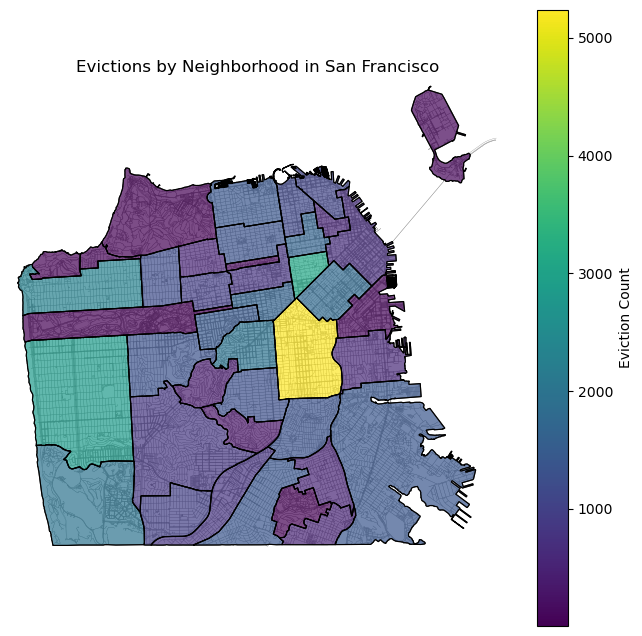

In [16]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Plot map of San Francisco with neighborhood boundaries
fig, ax = ox.plot_graph(sf, show=False, close=False, edge_color='grey', edge_linewidth=0.2, node_size=0, bgcolor='white')

# Get eviction count by neighborhood
eviction_count = ev_df.groupby('neighborhood').size().reset_index(name='count')

# Normalize the count values
norm = Normalize(vmin=eviction_count['count'].min(), vmax=eviction_count['count'].max())

# Create a scalar mappable with the viridis color map
sm = ScalarMappable(cmap='viridis', norm=norm)

# Add count to sf_neighborhoods
cols_to_use = list(sf_neighborhoods.columns.difference(eviction_count.columns)) + ['neighborhood']
sf_neighborhoods = sf_neighborhoods[cols_to_use].merge(eviction_count, left_on='neighborhood', right_on='neighborhood', how='left')

# Plot evictions by neighborhood
sf_neighborhoods.boundary.plot(ax=ax, color='black', linewidth=0.8)
sf_neighborhoods.plot(ax=ax, column='count', cmap='viridis', linewidth=0.8, edgecolor='black', alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(sm)
cbar.set_label('Eviction Count')

plt.title('Evictions by Neighborhood in San Francisco')
plt.gcf().set_facecolor('white')
plt.show()